# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
http://www.vahidmoosavi.com

https://github.com/sevamoo/sompy

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

from sklearn.preprocessing import StandardScaler

import os
import xarray as xr

import datetime

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
backend module://ipykernel.pylab.backend_inline version unknown


In [44]:
import math
import glob
import matplotlib
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import random

from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

import random

In [114]:
os.getcwd()

'C:\\Users\\goyetc\\SOMPY'

#### Prepare Data for Model
* Import data, view basic characteristics
* normalize
* Observe 2d abstraction of SOM results
* Extract cluster designations








In [2]:
DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
#DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [4]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['pCO2']['pCO2']], axis=1)

In [5]:
SOM_input.head()

,time,ylat,xlon,SSS,MLD,SST,pCO2
0,1982-01-16 12:00:00,-77.5,179.5,34.000992,16.192860,1.648732,151.525853
1,1982-01-16 12:00:00,-77.5,180.5,33.941429,15.115437,1.528921,150.330599
2,1982-01-16 12:00:00,-77.5,181.5,33.863464,14.071844,1.350243,148.500409
3,1982-01-16 12:00:00,-77.5,182.5,33.775764,13.072312,1.119088,146.198458
4,1982-01-16 12:00:00,-77.5,183.5,33.691376,12.333377,0.865820,143.769723


In [6]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

### Note above: 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

In [10]:
for i in range(12):
    print i+1

1
2
3
4
5
6
7
8
9
10
11
12


In [30]:
SOM_input.set_index(pd.DatetimeIndex(SOM_input['time']))
SOM_input['month'] = pd.DatetimeIndex(SOM_input['time']).month
Monthly = {}
for i in range(12):
    Monthly['month-'+str(i+1)] = SOM_input.loc[SOM_input['month'] == (i+1)]

In [24]:
Monthly.keys()

['month-10',
 'month-11',
 'month-12',
 'month-8',
 'month-9',
 'month-6',
 'month-7',
 'month-4',
 'month-5',
 'month-2',
 'month-3',
 'month-1']

In [36]:
for i in range(12):
    Monthly['month-'+str(i+1)] = Monthly['month-'+str(i+1)].drop(columns='month').sample(frac=1).reset_index(drop=True)
    Monthly['month-'+str(i+1)] = Monthly['month-'+str(i+1)].groupby(['ylat','xlon'], as_index=False).mean()

In [37]:
Monthly['month-1'].head(), Monthly['month-1'].shape

(   ylat   xlon        SSS        MLD       SST        pCO2
 0 -77.5  179.5  33.877541  15.948417  1.349778  155.399963
 1 -77.5  180.5  33.831253  15.072249  1.214095  153.832620
 2 -77.5  181.5  33.773590  14.233934  1.035777  151.635294
 3 -77.5  182.5  33.712555  13.452983  0.825134  149.043507
 4 -77.5  183.5  33.657063  12.789043  0.598411  146.350144, (41035, 6))

# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [134]:
#Prepare data

#log(MLD)
#means[['MLD']] = means[['MLD']].apply(np.log)

#scale
ss = StandardScaler().fit_transform(means[['SSS','SST','MLD','pCO2']])

In [41]:
#for i in range(12):
ss = StandardScaler().fit_transform(Monthly['month-'+str(i+1)][['SSS','SST','MLD','pCO2']])


C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [42]:
#tuning parameters
#research suggests M = 5*sqrt(N) is a good choice for number of neurons
M = 5*np.sqrt(ss.shape[0])
M
#insert source

1012.8548760804778

In [43]:
m=int(np.sqrt(M))
m

31

### Notes on SOM tuning
* testing suggests pca is faster than random init but limits # of epochs/trainlen internal to SOM engine
* batch faster than sequential

### From Original SOMtoolbox documentation
* http://www.cis.hut.fi/somtoolbox/package/docs2/som_quality.html

*     qe : Average distance between each data vector and its BMU.
       Measures map resolution.
*     te : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

#### Model 0 has the lowest topographic error so we will use these hyperparameters moving forward
* map size = [29,35]
* rectangular mapping
* pca initialization

In [162]:
mean_best.calculate_map_size('rect')


[29, 35]

In [169]:
mean_best.__dict__

{'_bmu': array([[  5.62000000e+02,   5.62000000e+02,   5.62000000e+02, ...,
           2.30000000e+01,   2.30000000e+01,   2.30000000e+01],
        [  1.79329921e+00,   1.80683533e+00,   1.81591119e+00, ...,
           1.35550033e-02,   1.41659069e-02,   1.47852844e-02]]),
 '_component_names': [['SSS', 'SST', 'MLD', 'pCO2']],
 '_data': array([[ 0.18913603, -1.3459917 ,  3.41670057, -2.6790296 ],
        [ 0.17588447, -1.3475531 ,  3.41021886, -2.69762985],
        [ 0.15916678, -1.34988534,  3.38340523, -2.72281208],
        ..., 
        [-0.84256275, -1.39285668, -0.15187448, -1.19543379],
        [-0.84284339, -1.39285576, -0.15225229, -1.19487994],
        [-0.84312895, -1.39285485, -0.15263131, -1.19433144]]),
 '_dim': 4L,
 '_distance_matrix': array([[  0.00000000e+00,   1.00000000e+00,   4.00000000e+00, ...,
           1.19060000e+04,   1.21250000e+04,   1.23460000e+04],
        [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
           1.16890000e+04,   1.19060000e+0

In [163]:
mean_best.calculate_topographic_error()

0.10807846959912271

In [164]:
mean_best.calculate_quantization_error()

0.10945089303776113

## Observe effects of various training lengths on best model from above
* Note: first pass, same performance was not achieved as the randomly achieved best performance as before. Nevertheless, decent topographical perf and and quant perf achieved
* Also note below that various training times do not significantly improve topographical error, and quantization error is basically flat. Implies we can achieve reasonable mapping with low(ish) epochs of rough/fine tuning

In [179]:
map_best = mean_best.calculate_map_size('rect')
names = ['SSS','SST','MLD','pCO2']

for i in range(12): 
    
    
    sm = sompy.SOMFactory().build(ss, mapsize = map_best, mapshape = 'planar',
                            initialization='pca',
                            normalization = 'var', 
                            component_names=names, lattice='rect') 
    sm.train(n_job=4, 
             verbose='info', 
             train_rough_len=random.choice(list(range(20,40))),
             train_finetune_len=random.choice(list(range(40,100))),
             #train_rough_radiusin=14,
             #train_rough_radiusfin=3.5,
             #train_finetune_radiusin=3.5,
             #train_finetune_radiusfin=1
            ) 
    
    joblib.dump(sm, "model_mean_opt_r3_epochs_{}.joblib".format(i))

 Training...
 pca_linear_initialization took: 0.054000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 32

 epoch: 1 ---> elapsed time:  0.387000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.390000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.397000, quantization error: 0.654553

 epoch: 4 ---> elapsed time:  0.390000, quantization error: 0.631314

 epoch: 5 ---> elapsed time:  0.391000, quantization error: 0.614198

 epoch: 6 ---> elapsed time:  0.396000, quantization error: 0.601104

 epoch: 7 ---> elapsed time:  0.387000, quantization error: 0.589545

 epoch: 8 ---> elapsed time:  0.387000, quantization error: 0.578247

 epoch: 9 ---> elapsed time:  0.387000, quantization error: 0.567044

 epoch: 10 ---> elapsed time:  0.387000, quantization error: 0.555391

 epoch: 11 ---> elapsed time:  0.388000, quantization error: 0.543574

 epoch: 12 ---> elapsed time:  0.388000, quantization error: 0.531560

 epoch: 13 --

 epoch: 82 ---> elapsed time:  0.389000, quantization error: 0.221726

 epoch: 83 ---> elapsed time:  0.392000, quantization error: 0.221453

 epoch: 84 ---> elapsed time:  0.396000, quantization error: 0.221170

 epoch: 85 ---> elapsed time:  0.402000, quantization error: 0.220880

 epoch: 86 ---> elapsed time:  0.391000, quantization error: 0.220592

 epoch: 87 ---> elapsed time:  0.398000, quantization error: 0.220300

 epoch: 88 ---> elapsed time:  0.391000, quantization error: 0.219984

 epoch: 89 ---> elapsed time:  0.390000, quantization error: 0.219694

 epoch: 90 ---> elapsed time:  0.390000, quantization error: 0.219369

 Final quantization error: 0.219369
 train took: 51.657000 seconds
 Training...
 pca_linear_initialization took: 0.060000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 35

 epoch: 1 ---> elapsed time:  0.387000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.393000, quantization error: 0.708758

 epoch: 3 

 epoch: 69 ---> elapsed time:  0.394000, quantization error: 0.224983

 epoch: 70 ---> elapsed time:  0.395000, quantization error: 0.224653

 epoch: 71 ---> elapsed time:  0.395000, quantization error: 0.224329

 epoch: 72 ---> elapsed time:  0.394000, quantization error: 0.224020

 epoch: 73 ---> elapsed time:  0.386000, quantization error: 0.223703

 epoch: 74 ---> elapsed time:  0.396000, quantization error: 0.223383

 epoch: 75 ---> elapsed time:  0.395000, quantization error: 0.223073

 epoch: 76 ---> elapsed time:  0.394000, quantization error: 0.222682

 epoch: 77 ---> elapsed time:  0.395000, quantization error: 0.222333

 epoch: 78 ---> elapsed time:  0.394000, quantization error: 0.222017

 epoch: 79 ---> elapsed time:  0.397000, quantization error: 0.221696

 epoch: 80 ---> elapsed time:  0.403000, quantization error: 0.221374

 epoch: 81 ---> elapsed time:  0.395000, quantization error: 0.221073

 epoch: 82 ---> elapsed time:  0.394000, quantization error: 0.220774

 epoch

 epoch: 60 ---> elapsed time:  0.393000, quantization error: 0.222064

 epoch: 61 ---> elapsed time:  0.394000, quantization error: 0.221645

 epoch: 62 ---> elapsed time:  0.394000, quantization error: 0.221228

 epoch: 63 ---> elapsed time:  0.393000, quantization error: 0.220825

 epoch: 64 ---> elapsed time:  0.394000, quantization error: 0.220415

 Final quantization error: 0.220415
 train took: 41.051000 seconds
 Training...
 pca_linear_initialization took: 0.071000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 30

 epoch: 1 ---> elapsed time:  0.395000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.394000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.496000, quantization error: 0.653962

 epoch: 4 ---> elapsed time:  0.399000, quantization error: 0.630058

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.612299

 epoch: 6 ---> elapsed time:  0.395000, quantization error: 0.598563

 epoch: 7 --->

 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 36

 epoch: 1 ---> elapsed time:  0.390000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.394000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.400000, quantization error: 0.655532

 epoch: 4 ---> elapsed time:  0.506000, quantization error: 0.633385

 epoch: 5 ---> elapsed time:  0.407000, quantization error: 0.617296

 epoch: 6 ---> elapsed time:  0.398000, quantization error: 0.605288

 epoch: 7 ---> elapsed time:  0.393000, quantization error: 0.594954

 epoch: 8 ---> elapsed time:  0.394000, quantization error: 0.585000

 epoch: 9 ---> elapsed time:  0.394000, quantization error: 0.575062

 epoch: 10 ---> elapsed time:  0.394000, quantization error: 0.565104

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.554767

 epoch: 12 ---> elapsed time:  0.393000, quantization error: 0.544426

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.533683

 epoc

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.492000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.457810

 epoch: 19 ---> elapsed time:  0.415000, quantization error: 0.445791

 epoch: 20 ---> elapsed time:  0.400000, quantization error: 0.433663

 epoch: 21 ---> elapsed time:  0.502000, quantization error: 0.421378

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.408959

 epoch: 23 ---> elapsed time:  0.402000, quantization error: 0.396386

 epoch: 24 ---> elapsed time:  0.394000, quantization error: 0.383763

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.371039

 epoch: 26 ---> elapsed time:  0.394000, quantization error: 0.358279

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.345440

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.332546

 epoch

 epoch: 6 ---> elapsed time:  0.395000, quantization error: 0.602259

 epoch: 7 ---> elapsed time:  0.395000, quantization error: 0.591004

 epoch: 8 ---> elapsed time:  0.396000, quantization error: 0.580081

 epoch: 9 ---> elapsed time:  0.393000, quantization error: 0.569208

 epoch: 10 ---> elapsed time:  0.397000, quantization error: 0.558059

 epoch: 11 ---> elapsed time:  0.402000, quantization error: 0.546622

 epoch: 12 ---> elapsed time:  0.394000, quantization error: 0.535077

 epoch: 13 ---> elapsed time:  0.400000, quantization error: 0.523051

 epoch: 14 ---> elapsed time:  0.391000, quantization error: 0.510671

 epoch: 15 ---> elapsed time:  0.399000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.395000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.399000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.401000, quantization error: 0.457810

 epoch: 19 ---> elapsed time:  0.396000, quantization error: 0.445791

 epoch: 20

 epoch: 5 ---> elapsed time:  0.401000, quantization error: 0.615039

 epoch: 6 ---> elapsed time:  0.398000, quantization error: 0.602259

 epoch: 7 ---> elapsed time:  0.394000, quantization error: 0.591004

 epoch: 8 ---> elapsed time:  0.393000, quantization error: 0.580081

 epoch: 9 ---> elapsed time:  0.392000, quantization error: 0.569208

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.558059

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.546622

 epoch: 12 ---> elapsed time:  0.397000, quantization error: 0.535077

 epoch: 13 ---> elapsed time:  0.392000, quantization error: 0.523051

 epoch: 14 ---> elapsed time:  0.394000, quantization error: 0.510671

 epoch: 15 ---> elapsed time:  0.390000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.396000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.392000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.457810

 epoch: 19 

 epoch: 5 ---> elapsed time:  0.397000, quantization error: 0.596560

 epoch: 6 ---> elapsed time:  0.397000, quantization error: 0.576985

 epoch: 7 ---> elapsed time:  0.396000, quantization error: 0.558249

 epoch: 8 ---> elapsed time:  0.395000, quantization error: 0.539270

 epoch: 9 ---> elapsed time:  0.394000, quantization error: 0.519083

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.498257

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.477052

 epoch: 12 ---> elapsed time:  0.394000, quantization error: 0.455629

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.433599

 epoch: 14 ---> elapsed time:  0.396000, quantization error: 0.411449

 epoch: 15 ---> elapsed time:  0.396000, quantization error: 0.389228

 epoch: 16 ---> elapsed time:  0.393000, quantization error: 0.366803

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.344548

 epoch: 18 ---> elapsed time:  0.392000, quantization error: 0.323022

 epoch: 19 

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.243623

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.243189

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.242779

 epoch: 18 ---> elapsed time:  0.392000, quantization error: 0.242352

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.241872

 epoch: 20 ---> elapsed time:  0.392000, quantization error: 0.241394

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.240923

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.240483

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.240065

 epoch: 24 ---> elapsed time:  0.395000, quantization error: 0.239671

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.239330

 epoch: 26 ---> elapsed time:  0.396000, quantization error: 0.238994

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.238637

 epoch: 28 ---> elapsed time:  0.394000, quantization error: 0.238299

 epoch

 epoch: 29 ---> elapsed time:  0.499000, quantization error: 0.239764

 epoch: 30 ---> elapsed time:  0.395000, quantization error: 0.239414

 epoch: 31 ---> elapsed time:  0.397000, quantization error: 0.239090

 epoch: 32 ---> elapsed time:  0.403000, quantization error: 0.238774

 epoch: 33 ---> elapsed time:  0.393000, quantization error: 0.238463

 epoch: 34 ---> elapsed time:  0.395000, quantization error: 0.238176

 epoch: 35 ---> elapsed time:  0.395000, quantization error: 0.237854

 epoch: 36 ---> elapsed time:  0.399000, quantization error: 0.237492

 epoch: 37 ---> elapsed time:  0.393000, quantization error: 0.237116

 epoch: 38 ---> elapsed time:  0.393000, quantization error: 0.236730

 epoch: 39 ---> elapsed time:  0.393000, quantization error: 0.236336

 epoch: 40 ---> elapsed time:  0.395000, quantization error: 0.235905

 epoch: 41 ---> elapsed time:  0.394000, quantization error: 0.235509

 epoch: 42 ---> elapsed time:  0.395000, quantization error: 0.235146

 epoch

 epoch: 16 ---> elapsed time:  0.396000, quantization error: 0.243316

 epoch: 17 ---> elapsed time:  0.500000, quantization error: 0.242867

 epoch: 18 ---> elapsed time:  0.398000, quantization error: 0.242445

 epoch: 19 ---> elapsed time:  0.395000, quantization error: 0.242059

 epoch: 20 ---> elapsed time:  0.395000, quantization error: 0.241645

 epoch: 21 ---> elapsed time:  0.395000, quantization error: 0.241281

 epoch: 22 ---> elapsed time:  0.397000, quantization error: 0.240885

 epoch: 23 ---> elapsed time:  0.394000, quantization error: 0.240468

 epoch: 24 ---> elapsed time:  0.393000, quantization error: 0.240020

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.239589

 epoch: 26 ---> elapsed time:  0.395000, quantization error: 0.239186

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.238813

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.238476

 epoch: 29 ---> elapsed time:  0.394000, quantization error: 0.238173

 epoch

 epoch: 4 ---> elapsed time:  0.394000, quantization error: 0.248791

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.247809

 epoch: 6 ---> elapsed time:  0.393000, quantization error: 0.246917

 epoch: 7 ---> elapsed time:  0.394000, quantization error: 0.246062

 epoch: 8 ---> elapsed time:  0.394000, quantization error: 0.245232

 epoch: 9 ---> elapsed time:  0.393000, quantization error: 0.244436

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.243734

 epoch: 11 ---> elapsed time:  0.393000, quantization error: 0.243014

 epoch: 12 ---> elapsed time:  0.393000, quantization error: 0.242251

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.241495

 epoch: 14 ---> elapsed time:  0.392000, quantization error: 0.240846

 epoch: 15 ---> elapsed time:  0.393000, quantization error: 0.240159

 epoch: 16 ---> elapsed time:  0.395000, quantization error: 0.239441

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.238679

 epoch: 18 -

 epoch: 40 ---> elapsed time:  0.398000, quantization error: 0.231691

 epoch: 41 ---> elapsed time:  0.505000, quantization error: 0.231197

 epoch: 42 ---> elapsed time:  0.398000, quantization error: 0.230710

 epoch: 43 ---> elapsed time:  0.397000, quantization error: 0.230201

 epoch: 44 ---> elapsed time:  0.498000, quantization error: 0.229746

 epoch: 45 ---> elapsed time:  0.399000, quantization error: 0.229306

 epoch: 46 ---> elapsed time:  0.499000, quantization error: 0.228830

 epoch: 47 ---> elapsed time:  0.394000, quantization error: 0.228396

 epoch: 48 ---> elapsed time:  0.396000, quantization error: 0.227967

 epoch: 49 ---> elapsed time:  0.394000, quantization error: 0.227503

 epoch: 50 ---> elapsed time:  0.395000, quantization error: 0.227026

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.226577

 epoch: 52 ---> elapsed time:  0.392000, quantization error: 0.226123

 epoch: 53 ---> elapsed time:  0.394000, quantization error: 0.225710

 epoch

 epoch: 11 ---> elapsed time:  0.397000, quantization error: 0.507766

 epoch: 12 ---> elapsed time:  0.395000, quantization error: 0.490490

 epoch: 13 ---> elapsed time:  0.395000, quantization error: 0.472856

 epoch: 14 ---> elapsed time:  0.393000, quantization error: 0.454811

 epoch: 15 ---> elapsed time:  0.392000, quantization error: 0.436250

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.417276

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.398507

 epoch: 18 ---> elapsed time:  0.393000, quantization error: 0.380961

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.363662

 epoch: 20 ---> elapsed time:  0.391000, quantization error: 0.346311

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.328695

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.310796

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.292639

 epoch: 24 ---> elapsed time:  0.394000, quantization error: 0.274369

 Finet

 epoch: 14 ---> elapsed time:  0.395000, quantization error: 0.445514

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.426163

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.406552

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.386914

 epoch: 18 ---> elapsed time:  0.395000, quantization error: 0.368196

 epoch: 19 ---> elapsed time:  0.394000, quantization error: 0.350279

 epoch: 20 ---> elapsed time:  0.394000, quantization error: 0.332086

 epoch: 21 ---> elapsed time:  0.394000, quantization error: 0.313523

 epoch: 22 ---> elapsed time:  0.394000, quantization error: 0.294601

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.275562

 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 49

 epoch: 1 ---> elapsed time:  0.507000, quantization error: 0.256768

 epoch: 2 ---> elapsed time:  0.497000, quantization error: 0.253339

 epoch: 3 ---> elapsed time:  0.394000, quantization error: 0.2512

 epoch: 15 ---> elapsed time:  0.393000, quantization error: 0.241199

 epoch: 16 ---> elapsed time:  0.392000, quantization error: 0.240561

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.239917

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.239282

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.238597

 epoch: 20 ---> elapsed time:  0.393000, quantization error: 0.237944

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.237354

 epoch: 22 ---> elapsed time:  0.395000, quantization error: 0.236772

 epoch: 23 ---> elapsed time:  0.394000, quantization error: 0.236196

 epoch: 24 ---> elapsed time:  0.393000, quantization error: 0.235611

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.235063

 epoch: 26 ---> elapsed time:  0.393000, quantization error: 0.234495

 epoch: 27 ---> elapsed time:  0.391000, quantization error: 0.233907

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.233288

 epoch

 epoch: 43 ---> elapsed time:  0.394000, quantization error: 0.229821

 epoch: 44 ---> elapsed time:  0.393000, quantization error: 0.229392

 epoch: 45 ---> elapsed time:  0.393000, quantization error: 0.228980

 epoch: 46 ---> elapsed time:  0.394000, quantization error: 0.228561

 epoch: 47 ---> elapsed time:  0.396000, quantization error: 0.228108

 epoch: 48 ---> elapsed time:  0.395000, quantization error: 0.227691

 epoch: 49 ---> elapsed time:  0.392000, quantization error: 0.227273

 epoch: 50 ---> elapsed time:  0.394000, quantization error: 0.226859

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.226446

 epoch: 52 ---> elapsed time:  0.392000, quantization error: 0.226036

 epoch: 53 ---> elapsed time:  0.394000, quantization error: 0.225605

 epoch: 54 ---> elapsed time:  0.394000, quantization error: 0.225186

 epoch: 55 ---> elapsed time:  0.394000, quantization error: 0.224767

 epoch: 56 ---> elapsed time:  0.392000, quantization error: 0.224359

 epoch

 epoch: 59 ---> elapsed time:  0.394000, quantization error: 0.228437

 epoch: 60 ---> elapsed time:  0.394000, quantization error: 0.228137

 epoch: 61 ---> elapsed time:  0.394000, quantization error: 0.227840

 epoch: 62 ---> elapsed time:  0.394000, quantization error: 0.227528

 epoch: 63 ---> elapsed time:  0.393000, quantization error: 0.227201

 epoch: 64 ---> elapsed time:  0.394000, quantization error: 0.226849

 epoch: 65 ---> elapsed time:  0.398000, quantization error: 0.226504

 epoch: 66 ---> elapsed time:  0.395000, quantization error: 0.226159

 epoch: 67 ---> elapsed time:  0.393000, quantization error: 0.225843

 epoch: 68 ---> elapsed time:  0.393000, quantization error: 0.225539

 epoch: 69 ---> elapsed time:  0.392000, quantization error: 0.225202

 epoch: 70 ---> elapsed time:  0.394000, quantization error: 0.224884

 epoch: 71 ---> elapsed time:  0.393000, quantization error: 0.224559

 epoch: 72 ---> elapsed time:  0.392000, quantization error: 0.224186

 epoch

In [45]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool_r3 = glob.glob("./model_mean_opt_r3*")
errors=[]
for model_filepath in models_pool_r3:
    sm_r3 = joblib.load(model_filepath)
    topographic_error = sm_r3.calculate_topographic_error()
    quantization_error = sm_r3.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top_r3, e_q_r3 = zip(*errors)

 find_bmu took: 5.650000 seconds
 find_bmu took: 0.849000 seconds
 find_bmu took: 0.733000 seconds
 find_bmu took: 0.728000 seconds
 find_bmu took: 0.774000 seconds
 find_bmu took: 0.744000 seconds
 find_bmu took: 0.728000 seconds
 find_bmu took: 0.843000 seconds
 find_bmu took: 0.737000 seconds
 find_bmu took: 0.740000 seconds
 find_bmu took: 0.829000 seconds
 find_bmu took: 0.651000 seconds
 find_bmu took: 0.752000 seconds
 find_bmu took: 0.823000 seconds
 find_bmu took: 0.659000 seconds
 find_bmu took: 0.728000 seconds
 find_bmu took: 0.856000 seconds
 find_bmu took: 0.731000 seconds
 find_bmu took: 0.733000 seconds
 find_bmu took: 0.830000 seconds
 find_bmu took: 0.739000 seconds
 find_bmu took: 0.686000 seconds
 find_bmu took: 0.772000 seconds
 find_bmu took: 0.655000 seconds
 find_bmu took: 0.680000 seconds
 find_bmu took: 0.854000 seconds
 find_bmu took: 0.748000 seconds
 find_bmu took: 0.732000 seconds
 find_bmu took: 0.933000 seconds
 find_bmu took: 0.835000 seconds
 find_bmu 

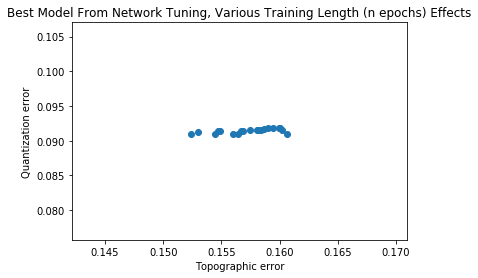

In [53]:
plt.scatter(e_top_r3, e_q_r3)
plt.title("Best Model From Network Tuning, Various Training Length (n epochs) Effects")
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

In [49]:
res = []
for i, model_filepath in enumerate(models_pool_r3):
    res.append({'model': model_filepath, 'topographical_error': e_top_r3[i], 'quantization_error': e_q_r3[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

results_df = pd.DataFrame(res)
results_df.sort_values(['topographical_error'], ascending=True)
#print(model_filepath,e_top[i],e_q[i])

,model,quantization_error,topographical_error
2,.\model_mean_opt_r3_epochs_10.joblib,0.090950,0.152431
8,.\model_mean_opt_r3_epochs_16.joblib,0.091271,0.152991
11,.\model_mean_opt_r3_epochs_19.joblib,0.090944,0.154454
18,.\model_mean_opt_r3_epochs_8.joblib,0.091472,0.154722
6,.\model_mean_opt_r3_epochs_14.joblib,0.091376,0.154843
13,.\model_mean_opt_r3_epochs_3.joblib,0.090950,0.156013
7,.\model_mean_opt_r3_epochs_15.joblib,0.090948,0.156452
0,.\model_mean_opt_r3_epochs_0.joblib,0.091345,0.156720
19,.\model_mean_opt_r3_epochs_9.joblib,0.091465,0.156890
17,.\model_mean_opt_r3_epochs_7.joblib,0.091553,0.157427


In [ ]:
Training...
 pca_linear_initialization took: 0.065000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 39
 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 78              

In [50]:
optimized = joblib.load('C:\\Users\goyetc\\SOMPY\\model_mean_opt_r3_epochs_10.joblib')
optimized.__dict__

{'_bmu': array([[  1.05000000e+02,   1.05000000e+02,   1.05000000e+02, ...,
           8.62000000e+02,   8.62000000e+02,   8.62000000e+02],
        [  1.65762096e+00,   1.67275687e+00,   1.68548998e+00, ...,
           2.49997359e-02,   2.46383805e-02,   2.42878250e-02]]),
 '_component_names': [['SSS', 'SST', 'MLD', 'pCO2']],
 '_data': array([[ 0.18913603, -1.3459917 ,  3.41670057, -2.6790296 ],
        [ 0.17588447, -1.3475531 ,  3.41021886, -2.69762985],
        [ 0.15916678, -1.34988534,  3.38340523, -2.72281208],
        ..., 
        [-0.84256275, -1.39285668, -0.15187448, -1.19543379],
        [-0.84284339, -1.39285576, -0.15225229, -1.19487994],
        [-0.84312895, -1.39285485, -0.15263131, -1.19433144]]),
 '_dim': 4L,
 '_distance_matrix': array([[  0.00000000e+00,   1.00000000e+00,   4.00000000e+00, ...,
           1.80800000e+03,   1.87300000e+03,   1.94000000e+03],
        [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
           1.74500000e+03,   1.80800000e+0

In [51]:
optimized.calculate_topographic_error()

 find_bmu took: 0.674000 seconds
 find_bmu took: 0.862000 seconds


0.1524308517119532

In [52]:
# based on prior optimization
map_best = [29, 35] 
initialization = 'pca'
names = ['SSS','SST','MLD','pCO2']
tr = 40
tf = 80

for i in range(12):
    ss = StandardScaler().fit_transform(Monthly['month-'+str(i+1)][['SSS','SST','MLD','pCO2']])
    
    
    sm = sompy.SOMFactory().build(ss, mapsize = map_best, mapshape = 'planar',
                            initialization='pca',
                            normalization = 'var', 
                            component_names=names, lattice='rect') 
    sm.train(n_job=4, 
             verbose='info', 
             train_rough_len=tr,
             train_finetune_len=tf,
             #train_rough_radiusin=14,
             #train_rough_radiusfin=3.5,
             #train_finetune_radiusin=3.5,
             #train_finetune_radiusfin=1
            ) 
    
    joblib.dump(sm, "optimized_month_{}.joblib".format(i+1))

 Training...
 pca_linear_initialization took: 0.057000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 40

 epoch: 1 ---> elapsed time:  0.417000, quantization error: 0.945555

 epoch: 2 ---> elapsed time:  0.387000, quantization error: 0.746439

 epoch: 3 ---> elapsed time:  0.387000, quantization error: 0.623160

 epoch: 4 ---> elapsed time:  0.486000, quantization error: 0.599353

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.585753

 epoch: 6 ---> elapsed time:  0.393000, quantization error: 0.572083

 epoch: 7 ---> elapsed time:  0.499000, quantization error: 0.558950

 epoch: 8 ---> elapsed time:  0.396000, quantization error: 0.545512

 epoch: 9 ---> elapsed time:  0.386000, quantization error: 0.532578

 epoch: 10 ---> elapsed time:  0.396000, quantization error: 0.520324

 epoch: 11 ---> elapsed time:  0.400000, quantization error: 0.508824

 epoch: 12 ---> elapsed time:  0.411000, quantization error: 0.498042

 epoch: 13 --

 epoch: 74 ---> elapsed time:  0.519000, quantization error: 0.171854

 epoch: 75 ---> elapsed time:  0.393000, quantization error: 0.171559

 epoch: 76 ---> elapsed time:  0.600000, quantization error: 0.171246

 epoch: 77 ---> elapsed time:  0.614000, quantization error: 0.170948

 epoch: 78 ---> elapsed time:  0.604000, quantization error: 0.170631

 epoch: 79 ---> elapsed time:  0.507000, quantization error: 0.170313

 epoch: 80 ---> elapsed time:  0.496000, quantization error: 0.170004

 Final quantization error: 0.170004
 train took: 55.146000 seconds
 Training...
 pca_linear_initialization took: 0.082000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 40

 epoch: 1 ---> elapsed time:  0.414000, quantization error: 0.920243

 epoch: 2 ---> elapsed time:  0.604000, quantization error: 0.677262

 epoch: 3 ---> elapsed time:  0.605000, quantization error: 0.599796

 epoch: 4 ---> elapsed time:  0.602000, quantization error: 0.569986

 epoch: 5 --

 epoch: 66 ---> elapsed time:  0.397000, quantization error: 0.174822

 epoch: 67 ---> elapsed time:  0.397000, quantization error: 0.174503

 epoch: 68 ---> elapsed time:  0.396000, quantization error: 0.174192

 epoch: 69 ---> elapsed time:  0.397000, quantization error: 0.173873

 epoch: 70 ---> elapsed time:  0.398000, quantization error: 0.173550

 epoch: 71 ---> elapsed time:  0.397000, quantization error: 0.173257

 epoch: 72 ---> elapsed time:  0.397000, quantization error: 0.172960

 epoch: 73 ---> elapsed time:  0.411000, quantization error: 0.172638

 epoch: 74 ---> elapsed time:  0.511000, quantization error: 0.172302

 epoch: 75 ---> elapsed time:  0.403000, quantization error: 0.172002

 epoch: 76 ---> elapsed time:  0.398000, quantization error: 0.171664

 epoch: 77 ---> elapsed time:  0.487000, quantization error: 0.171340

 epoch: 78 ---> elapsed time:  0.483000, quantization error: 0.170997

 epoch: 79 ---> elapsed time:  0.512000, quantization error: 0.170696

 epoch

 epoch: 58 ---> elapsed time:  0.399000, quantization error: 0.176049

 epoch: 59 ---> elapsed time:  0.395000, quantization error: 0.175726

 epoch: 60 ---> elapsed time:  0.398000, quantization error: 0.175380

 epoch: 61 ---> elapsed time:  0.396000, quantization error: 0.175036

 epoch: 62 ---> elapsed time:  0.399000, quantization error: 0.174696

 epoch: 63 ---> elapsed time:  0.416000, quantization error: 0.174355

 epoch: 64 ---> elapsed time:  0.397000, quantization error: 0.174038

 epoch: 65 ---> elapsed time:  0.400000, quantization error: 0.173686

 epoch: 66 ---> elapsed time:  0.397000, quantization error: 0.173323

 epoch: 67 ---> elapsed time:  0.397000, quantization error: 0.172951

 epoch: 68 ---> elapsed time:  0.401000, quantization error: 0.172620

 epoch: 69 ---> elapsed time:  0.399000, quantization error: 0.172290

 epoch: 70 ---> elapsed time:  0.404000, quantization error: 0.171965

 epoch: 71 ---> elapsed time:  0.398000, quantization error: 0.171626

 epoch

 epoch: 50 ---> elapsed time:  0.397000, quantization error: 0.195937

 epoch: 51 ---> elapsed time:  0.397000, quantization error: 0.195614

 epoch: 52 ---> elapsed time:  0.413000, quantization error: 0.195262

 epoch: 53 ---> elapsed time:  0.396000, quantization error: 0.194926

 epoch: 54 ---> elapsed time:  0.396000, quantization error: 0.194563

 epoch: 55 ---> elapsed time:  0.513000, quantization error: 0.194240

 epoch: 56 ---> elapsed time:  0.420000, quantization error: 0.193890

 epoch: 57 ---> elapsed time:  0.407000, quantization error: 0.193563

 epoch: 58 ---> elapsed time:  0.393000, quantization error: 0.193162

 epoch: 59 ---> elapsed time:  0.498000, quantization error: 0.192720

 epoch: 60 ---> elapsed time:  0.397000, quantization error: 0.192302

 epoch: 61 ---> elapsed time:  0.398000, quantization error: 0.191921

 epoch: 62 ---> elapsed time:  0.395000, quantization error: 0.191541

 epoch: 63 ---> elapsed time:  0.398000, quantization error: 0.191174

 epoch

 epoch: 42 ---> elapsed time:  0.399000, quantization error: 0.235665

 epoch: 43 ---> elapsed time:  0.394000, quantization error: 0.235241

 epoch: 44 ---> elapsed time:  0.398000, quantization error: 0.234807

 epoch: 45 ---> elapsed time:  0.497000, quantization error: 0.234425

 epoch: 46 ---> elapsed time:  0.402000, quantization error: 0.234014

 epoch: 47 ---> elapsed time:  0.406000, quantization error: 0.233601

 epoch: 48 ---> elapsed time:  0.399000, quantization error: 0.233200

 epoch: 49 ---> elapsed time:  0.398000, quantization error: 0.232796

 epoch: 50 ---> elapsed time:  0.396000, quantization error: 0.232388

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.231970

 epoch: 52 ---> elapsed time:  0.412000, quantization error: 0.231571

 epoch: 53 ---> elapsed time:  0.407000, quantization error: 0.231134

 epoch: 54 ---> elapsed time:  0.426000, quantization error: 0.230694

 epoch: 55 ---> elapsed time:  0.397000, quantization error: 0.230281

 epoch

 epoch: 34 ---> elapsed time:  0.393000, quantization error: 0.199689

 epoch: 35 ---> elapsed time:  0.388000, quantization error: 0.199411

 epoch: 36 ---> elapsed time:  0.498000, quantization error: 0.199131

 epoch: 37 ---> elapsed time:  0.509000, quantization error: 0.198825

 epoch: 38 ---> elapsed time:  0.407000, quantization error: 0.198503

 epoch: 39 ---> elapsed time:  0.486000, quantization error: 0.198210

 epoch: 40 ---> elapsed time:  0.528000, quantization error: 0.197896

 epoch: 41 ---> elapsed time:  0.398000, quantization error: 0.197579

 epoch: 42 ---> elapsed time:  0.503000, quantization error: 0.197281

 epoch: 43 ---> elapsed time:  0.708000, quantization error: 0.196972

 epoch: 44 ---> elapsed time:  0.500000, quantization error: 0.196658

 epoch: 45 ---> elapsed time:  0.608000, quantization error: 0.196335

 epoch: 46 ---> elapsed time:  0.541000, quantization error: 0.196045

 epoch: 47 ---> elapsed time:  0.619000, quantization error: 0.195734

 epoch

 epoch: 26 ---> elapsed time:  0.382000, quantization error: 0.165107

 epoch: 27 ---> elapsed time:  0.401000, quantization error: 0.164818

 epoch: 28 ---> elapsed time:  0.414000, quantization error: 0.164535

 epoch: 29 ---> elapsed time:  0.497000, quantization error: 0.164257

 epoch: 30 ---> elapsed time:  0.402000, quantization error: 0.163987

 epoch: 31 ---> elapsed time:  0.516000, quantization error: 0.163714

 epoch: 32 ---> elapsed time:  0.495000, quantization error: 0.163434

 epoch: 33 ---> elapsed time:  0.408000, quantization error: 0.163200

 epoch: 34 ---> elapsed time:  0.425000, quantization error: 0.162940

 epoch: 35 ---> elapsed time:  0.496000, quantization error: 0.162674

 epoch: 36 ---> elapsed time:  0.404000, quantization error: 0.162429

 epoch: 37 ---> elapsed time:  0.494000, quantization error: 0.162155

 epoch: 38 ---> elapsed time:  0.393000, quantization error: 0.161889

 epoch: 39 ---> elapsed time:  0.389000, quantization error: 0.161623

 epoch

 epoch: 18 ---> elapsed time:  0.512000, quantization error: 0.162769

 epoch: 19 ---> elapsed time:  0.529000, quantization error: 0.162483

 epoch: 20 ---> elapsed time:  0.404000, quantization error: 0.162203

 epoch: 21 ---> elapsed time:  0.399000, quantization error: 0.161934

 epoch: 22 ---> elapsed time:  0.413000, quantization error: 0.161669

 epoch: 23 ---> elapsed time:  0.411000, quantization error: 0.161390

 epoch: 24 ---> elapsed time:  0.414000, quantization error: 0.161127

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.160839

 epoch: 26 ---> elapsed time:  0.420000, quantization error: 0.160564

 epoch: 27 ---> elapsed time:  0.399000, quantization error: 0.160300

 epoch: 28 ---> elapsed time:  0.402000, quantization error: 0.160033

 epoch: 29 ---> elapsed time:  0.421000, quantization error: 0.159786

 epoch: 30 ---> elapsed time:  0.518000, quantization error: 0.159515

 epoch: 31 ---> elapsed time:  0.580000, quantization error: 0.159259

 epoch

 epoch: 10 ---> elapsed time:  0.488000, quantization error: 0.172969

 epoch: 11 ---> elapsed time:  0.495000, quantization error: 0.172600

 epoch: 12 ---> elapsed time:  0.417000, quantization error: 0.172276

 epoch: 13 ---> elapsed time:  0.415000, quantization error: 0.171946

 epoch: 14 ---> elapsed time:  0.486000, quantization error: 0.171610

 epoch: 15 ---> elapsed time:  0.489000, quantization error: 0.171275

 epoch: 16 ---> elapsed time:  0.416000, quantization error: 0.170938

 epoch: 17 ---> elapsed time:  0.485000, quantization error: 0.170663

 epoch: 18 ---> elapsed time:  0.487000, quantization error: 0.170373

 epoch: 19 ---> elapsed time:  0.488000, quantization error: 0.170089

 epoch: 20 ---> elapsed time:  0.513000, quantization error: 0.169802

 epoch: 21 ---> elapsed time:  0.415000, quantization error: 0.169521

 epoch: 22 ---> elapsed time:  0.388000, quantization error: 0.169206

 epoch: 23 ---> elapsed time:  0.395000, quantization error: 0.168873

 epoch

 epoch: 2 ---> elapsed time:  0.491000, quantization error: 0.210913

 epoch: 3 ---> elapsed time:  0.477000, quantization error: 0.209846

 epoch: 4 ---> elapsed time:  0.487000, quantization error: 0.209042

 epoch: 5 ---> elapsed time:  0.500000, quantization error: 0.208135

 epoch: 6 ---> elapsed time:  0.477000, quantization error: 0.207317

 epoch: 7 ---> elapsed time:  0.497000, quantization error: 0.206706

 epoch: 8 ---> elapsed time:  0.399000, quantization error: 0.206271

 epoch: 9 ---> elapsed time:  0.502000, quantization error: 0.205920

 epoch: 10 ---> elapsed time:  0.494000, quantization error: 0.205494

 epoch: 11 ---> elapsed time:  0.481000, quantization error: 0.204975

 epoch: 12 ---> elapsed time:  0.507000, quantization error: 0.204511

 epoch: 13 ---> elapsed time:  0.417000, quantization error: 0.204079

 epoch: 14 ---> elapsed time:  0.413000, quantization error: 0.203684

 epoch: 15 ---> elapsed time:  0.422000, quantization error: 0.203328

 epoch: 16 ---

 epoch: 35 ---> elapsed time:  0.494000, quantization error: 0.305913

 epoch: 36 ---> elapsed time:  0.409000, quantization error: 0.295133

 epoch: 37 ---> elapsed time:  0.412000, quantization error: 0.284436

 epoch: 38 ---> elapsed time:  0.425000, quantization error: 0.273973

 epoch: 39 ---> elapsed time:  0.392000, quantization error: 0.263468

 epoch: 40 ---> elapsed time:  0.409000, quantization error: 0.253015

 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 80

 epoch: 1 ---> elapsed time:  0.400000, quantization error: 0.242719

 epoch: 2 ---> elapsed time:  0.397000, quantization error: 0.241221

 epoch: 3 ---> elapsed time:  0.395000, quantization error: 0.239982

 epoch: 4 ---> elapsed time:  0.394000, quantization error: 0.238999

 epoch: 5 ---> elapsed time:  0.397000, quantization error: 0.238154

 epoch: 6 ---> elapsed time:  0.412000, quantization error: 0.237441

 epoch: 7 ---> elapsed time:  0.416000, quantization error: 0.236818



 epoch: 27 ---> elapsed time:  0.411000, quantization error: 0.376708

 epoch: 28 ---> elapsed time:  0.411000, quantization error: 0.365355

 epoch: 29 ---> elapsed time:  0.412000, quantization error: 0.354068

 epoch: 30 ---> elapsed time:  0.396000, quantization error: 0.342706

 epoch: 31 ---> elapsed time:  0.404000, quantization error: 0.331524

 epoch: 32 ---> elapsed time:  0.513000, quantization error: 0.319967

 epoch: 33 ---> elapsed time:  0.500000, quantization error: 0.308563

 epoch: 34 ---> elapsed time:  0.498000, quantization error: 0.297260

 epoch: 35 ---> elapsed time:  0.626000, quantization error: 0.286212

 epoch: 36 ---> elapsed time:  0.410000, quantization error: 0.275296

 epoch: 37 ---> elapsed time:  0.406000, quantization error: 0.264528

 epoch: 38 ---> elapsed time:  0.520000, quantization error: 0.254049

 epoch: 39 ---> elapsed time:  0.600000, quantization error: 0.243599

 epoch: 40 ---> elapsed time:  0.509000, quantization error: 0.233142

 Finet

In [54]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool_opt_m = glob.glob("./optimized_month*")
errors=[]
for model_filepath in models_pool_opt_m:
    sm_opt_m = joblib.load(model_filepath)
    topographic_error = sm_opt_m.calculate_topographic_error()
    quantization_error = sm_opt_m.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top_opt_m, e_q_opt_m = zip(*errors)

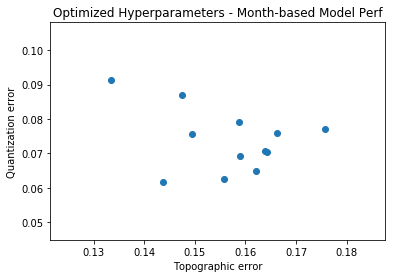

In [56]:
plt.scatter(e_top_opt_m, e_q_opt_m)
plt.title("Optimized Hyperparameters - Month-based Model Perf")
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.savefig('Optimized_Model_Monthly_Top_Quant_Errors.png')
plt.show()

In [58]:
monthly_model_perf = []
for i, model_filepath in enumerate(models_pool_opt_m):
    monthly_model_perf.append({'model': model_filepath, 'topographical_error': e_top_opt_m[i], 'quantization_error': e_q_opt_m[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

month_perf = pd.DataFrame(monthly_model_perf)
month_perf.sort_values(['topographical_error'], ascending=True)
#print(model_filepath,e_top[i],e_q[i])

,model,quantization_error,topographical_error
7,.\optimized_month_5.joblib,0.091407,0.133423
10,.\optimized_month_8.joblib,0.061564,0.143658
2,.\optimized_month_11.joblib,0.086847,0.147459
6,.\optimized_month_4.joblib,0.075683,0.149482
9,.\optimized_month_7.joblib,0.062668,0.155843
3,.\optimized_month_12.joblib,0.079049,0.158694
5,.\optimized_month_3.joblib,0.069300,0.158889
11,.\optimized_month_9.joblib,0.064769,0.162032
0,.\optimized_month_1.joblib,0.070629,0.163909
4,.\optimized_month_2.joblib,0.070287,0.164323


In [63]:
for i in range(12):
    som = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_{}.joblib'.format(i+1))
    map_labels_k5 = som.cluster(n_clusters=5)
    data_labels_k5 = np.array([map_labels_k5[int(k)] for k in som._bmu[0]])
    map_labels_k10 = som.cluster(n_clusters=10)
    data_labels_k10 = np.array([map_labels_k10[int(k)] for k in som._bmu[0]])
    map_labels_k15 = som.cluster(n_clusters=15)
    data_labels_k15 = np.array([map_labels_k15[int(k)] for k in som._bmu[0]])
    
    Monthly['month-{}'.format(i+1)]['k=5'] = data_labels_k5
    Monthly['month-{}'.format(i+1)]['k=10'] = data_labels_k10
    Monthly['month-{}'.format(i+1)]['k=15'] = data_labels_k15
    
    Monthly['month-{}'.format(i+1)].to_csv('C:\\Users\\goyetc\\ocean-co2-absorption\\notebooks\\SOM\\SOM_Month_{}.csv'.format(i+1),
                  sep=',',
                  na_rep='NaN',
                  columns=[u'ylat', u'xlon', u'SSS', u'MLD', u'SST', u'pCO2', u'k=5', u'k=10', u'k=15'],
                  header=True,
                  index=True,
                  mode='w')

In [64]:
Monthly['month-2'].sample(10)

,ylat,xlon,SSS,MLD,SST,pCO2,k=5,k=10,k=15
18671,-13.5,346.5,36.294323,38.994919,25.494459,373.012956,2,0,7
39912,86.5,317.5,33.161171,79.945076,-1.801534,344.781629,0,1,13
13807,-30.5,14.5,34.762211,28.291983,20.710423,357.380964,2,0,7
7086,-51.5,324.5,33.574509,37.789185,7.450382,247.412134,4,7,3
17261,-18.5,255.5,36.219727,52.492203,24.801188,389.998410,2,0,7
29016,27.5,143.5,34.494514,107.625160,19.369177,304.221090,2,2,0
7218,-50.5,96.5,33.762821,53.730377,8.088168,304.816390,4,7,3
20935,-4.5,78.5,33.607609,50.950848,28.088097,360.537081,2,8,11
10829,-40.5,238.5,34.139713,31.738649,17.431696,395.392641,2,0,5
25016,10.5,176.5,34.009727,81.422745,26.756647,334.023750,2,8,11
